In [ ]:
import pandas as pd
df=pd.read_csv("top_20_corr.csv")
df.shape

(905832, 111)

In [57]:
# 💾 Script LightGBM para predecir tn en febrero 2020

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datos
df = pd.read_csv("top_20_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)

# 4. Agregar variable mes
df_lags['mes'] = df_lags['periodo'].dt.month

# 5. Eliminar filas con NaN por los lags
df_train = df_lags.dropna()

# 6. Separar features y target
# Usá todas excepto tn, periodo y product_id
features = [col for col in df_train.columns if col not in ['tn', 'periodo', 'product_id']]

target = 'tn'

# 7. Separar train y validación
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

# 8. Hiperparámetros de Optuna
mejores_params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'n_estimators': 332,
    'learning_rate': 0.04554426553090496,
    'max_depth': 12,
    'num_leaves': 220,
    'subsample': 0.8186854672922206,
    'colsample_bytree': 0.8937328664099052,
    'random_state': 42,
    'min_data_in_leaf': 136,
    'reg_alpha': 0.8528548427029405,
    'reg_lambda': 1.4844753667444177,
    'linear_tree': True
}

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 9. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 10. Predicción enero 2020
enero_df = df_prod[df_prod['periodo'] == '2019-12-01'].copy()
enero_df['periodo'] = pd.to_datetime('2020-01-01')
enero_df['lag_1'] = df_prod[df_prod['periodo'] == '2019-12-01']['tn'].values
enero_df['lag_2'] = df_prod[df_prod['periodo'] == '2019-11-01']['tn'].values
enero_df['lag_3'] = df_prod[df_prod['periodo'] == '2019-10-01']['tn'].values
enero_df['mes'] = 1
enero_df['tn'] = modelo.predict(enero_df[features])

# 11. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = enero_df['product_id']
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['lag_1'] = enero_df['tn']  # predicción enero
feb_df['lag_2'] = df_prod[df_prod['periodo'] == '2019-12-01']['tn'].values
feb_df['lag_3'] = df_prod[df_prod['periodo'] == '2019-11-01']['tn'].values
feb_df['mes'] = 2
feb_df['tn_predicho'] = modelo.predict(feb_df[features])

# 12. Exportar resultados
resultado = feb_df[['product_id', 'tn_predicho']]
resultado.to_csv("prediccion_feb2020_top201.csv", index=False)
print("✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top201.csv")

[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 4512, number of used features: 4
[LightGBM] [Info] Start training from score 44,461989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,002976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21293
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 107
[LightGBM] [Info] Start training from score 157,574272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

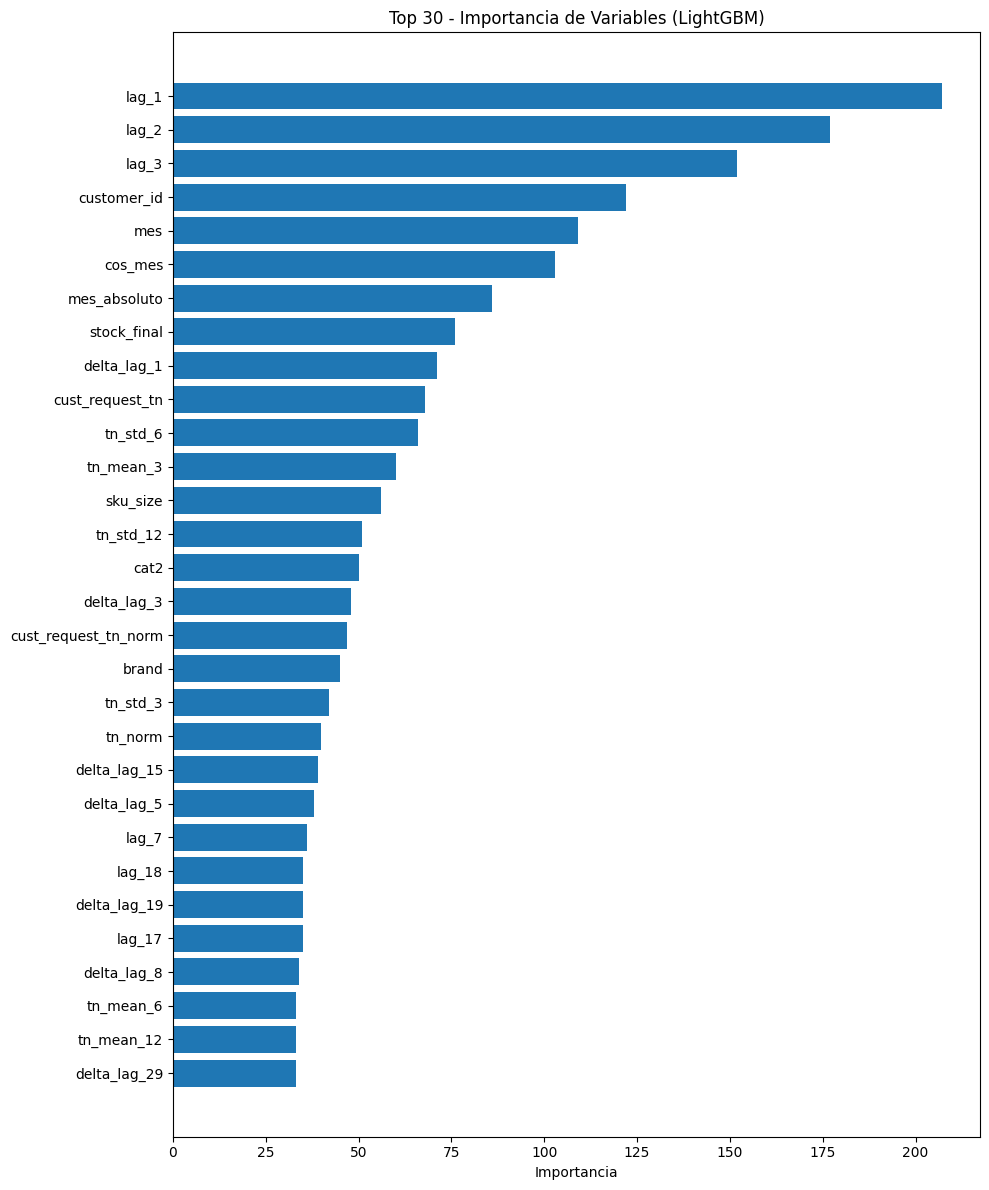

[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top303.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\2329197197.py:110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feb_df[col] = df_base[df_base['periodo'] == '2019-12-01'][col].values
C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\2329197197.py:110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feb_df[col] = df_base[df_base['periodo'] == '2019-12-01'][col].values
C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\2329197197.py:110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [49]:
# 💾 Script LightGBM usando todas las features disponibles

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar dataset completo
df = pd.read_csv("top_30_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Separar columnas base
otras_features = [col for col in df.columns if col not in ['product_id', 'periodo', 'tn']]

# 3. Agregar ventas por producto y mes
ventas = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()
otras = df.groupby(['product_id', 'periodo'])[otras_features].first().reset_index()
df_base = pd.merge(ventas, otras, on=['product_id', 'periodo'], how='left')

# 4. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_base)

# 5. Agregar variable mes
df_lags['mes'] = df_lags['periodo'].dt.month

# 6. Eliminar filas con NaN por los lags
df_train = df_lags.dropna()

# 7. Separar features y target
features = [col for col in df_train.columns if col not in ['tn', 'periodo', 'product_id']]
target = 'tn'

# 8. Separar train y validación
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

# 9. Hiperparámetros Optuna (ajustados)
mejores_params = {
    'n_estimators': 332,
    'learning_rate': 0.04554426553090496,
    'max_depth': 12,
    'num_leaves': 220,
    'subsample': 0.8186854672922206,
    'colsample_bytree': 0.8937328664099052,
    'random_state': 42,
    'min_data_in_leaf': 136,
    'reg_alpha': 0.8528548427029405,
    'reg_lambda': 1.4844753667444177,
    'linear_tree': True
}

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 10. Validación
y_pred_val = modelo.predict(X_val)
print("\ud83d\udcca MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 11. Importancia de variables
import matplotlib.pyplot as plt

importancia = modelo.feature_importances_
df_importancia = pd.DataFrame({
    'feature': features,
    'importance': importancia
}).sort_values(by='importance', ascending=False)

print("\n\ud83d\udcca Importancia de variables:")
print(df_importancia)

plt.figure(figsize=(10, 12))
plt.barh(df_importancia['feature'].head(30)[::-1], df_importancia['importance'].head(30)[::-1])
plt.title("Top 30 - Importancia de Variables (LightGBM)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.savefig("importancia_variables_full.png", dpi=300)
plt.show()

# 12. Predicción enero 2020
enero_df = df_base[df_base['periodo'] == '2019-12-01'].copy()
enero_df['periodo'] = pd.to_datetime('2020-01-01')
enero_df['lag_1'] = df_base[df_base['periodo'] == '2019-12-01']['tn'].values
enero_df['lag_2'] = df_base[df_base['periodo'] == '2019-11-01']['tn'].values
enero_df['lag_3'] = df_base[df_base['periodo'] == '2019-10-01']['tn'].values
enero_df['mes'] = 1
enero_df['tn'] = modelo.predict(enero_df[features])

# 13. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = enero_df['product_id']
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['lag_1'] = enero_df['tn']
feb_df['lag_2'] = df_base[df_base['periodo'] == '2019-12-01']['tn'].values
feb_df['lag_3'] = df_base[df_base['periodo'] == '2019-11-01']['tn'].values
feb_df['mes'] = 2

# Completar otras features (usamos mismas que en diciembre por ahora)
for col in otras_features:
    feb_df[col] = df_base[df_base['periodo'] == '2019-12-01'][col].values

# Predecir febrero
feb_df['tn_predicho'] = modelo.predict(feb_df[features])

# 14. Exportar resultados
resultado = feb_df[['product_id', 'tn_predicho']]
resultado.to_csv("prediccion_feb2020_top303.csv", index=False)
print("✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top303.csv")


In [58]:
import pandas as pd

# 1. Cargar predicción febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top201.csv")  # columnas: product_id, tn_predicho
total_pred_febrero = df_pred["tn_predicho"].sum()

# 2. Cargar dataset real
df_real = pd.read_csv("top_20_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar toneladas reales por período
totales_reales = df_real.groupby("periodo")["tn"].sum().reset_index()

# 4. Agregar fila con predicción febrero 2020
fila_predicha = pd.DataFrame({
    "periodo": [pd.to_datetime("2020-02-01")],
    "tn": [total_pred_febrero]
})

comparacion = pd.concat([totales_reales, fila_predicha], ignore_index=True)
comparacion = comparacion.sort_values("periodo")

# 5. Mostrar resultado
print("\n📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.to_string(index=False))



📊 Total de toneladas por período (incluye predicción febrero 2020):
   periodo           tn
2017-01-01 5.835243e+03
2017-02-01 5.702329e+03
2017-03-01 6.990975e+03
2017-04-01 5.915823e+03
2017-05-01 6.350694e+03
2017-06-01 6.246930e+03
2017-07-01 4.963103e+03
2017-08-01 5.394166e+03
2017-09-01 6.456906e+03
2017-10-01 7.469617e+03
2017-11-01 6.673993e+03
2017-12-01 5.439857e+03
2018-01-01 5.008785e+03
2018-02-01 5.276024e+03
2018-03-01 8.091699e+03
2018-04-01 5.935535e+03
2018-05-01 6.872361e+03
2018-06-01 6.240220e+03
2018-07-01 5.481642e+03
2018-08-01 6.211813e+03
2018-09-01 5.654182e+03
2018-10-01 6.470026e+03
2018-11-01 6.228278e+03
2018-12-01 4.976508e+03
2019-01-01 5.998070e+03
2019-02-01 6.210342e+03
2019-03-01 6.873227e+03
2019-04-01 6.573771e+03
2019-05-01 6.877301e+03
2019-06-01 6.301710e+03
2019-07-01 6.554508e+03
2019-08-01 5.666679e+03
2019-09-01 7.172001e+03
2019-10-01 7.370982e+03
2019-11-01 7.655744e+03
2019-12-01 5.356053e+03
2020-02-01 2.704535e+06



📊 Importancia de variables:
  feature  importance
0   lag_1        2000
2   lag_3        1747
1   lag_2        1606
3     mes         934


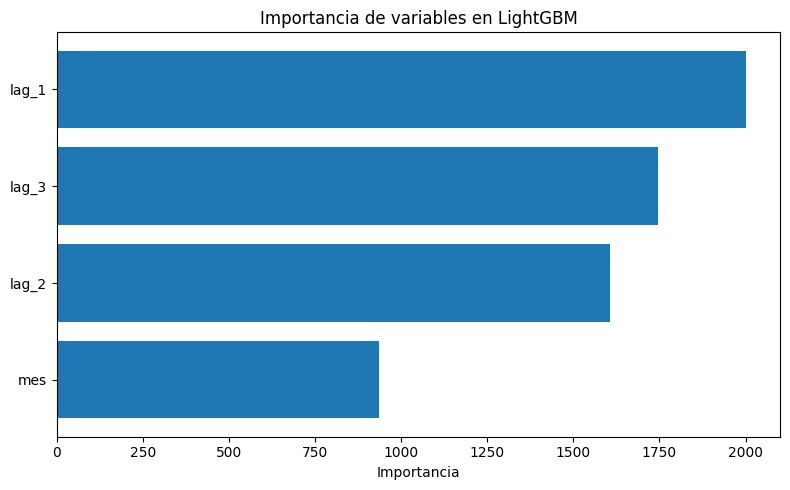

In [59]:
# 9bis. Importancia de variables
import matplotlib.pyplot as plt

importancia = modelo.feature_importances_
df_importancia = pd.DataFrame({
    'feature': features,
    'importance': importancia
}).sort_values(by='importance', ascending=False)

print("\n📊 Importancia de variables:")
print(df_importancia)

# Gráfico
plt.figure(figsize=(8, 5))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables en LightGBM")
plt.xlabel("Importancia")
plt.tight_layout()
plt.savefig("importancia_variables.png", dpi=300)
plt.show()


In [36]:
print(df_importancia[df_importancia["importance"] > 0])


  feature  importance
1   lag_2        7387
0   lag_1        7380
2   lag_3        7226
3     mes        4243


In [37]:
constantes = X_train.loc[:, X_train.nunique() <= 1]
print(f"🔍 Variables constantes: {constantes.shape[1]}")


🔍 Variables constantes: 0


In [38]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=1e-5)
selector.fit(X_train)
mask = selector.get_support()
print(f"🔍 Variables que pasan el umbral de varianza: {mask.sum()}/{X_train.shape[1]}")


🔍 Variables que pasan el umbral de varianza: 4/4


In [ ]:
no_usadas = df_importancia[df_importancia["importance"] == 0]["feature"].tolist()
X_testeo = X_train[no_usadas]

modelo_test = lgb.LGBMRegressor(**mejores_params)
modelo_test.fit(X_testeo, y_train)

print("R² usando solo features no utilizadas originalmente:", modelo_test.score(X_testeo, y_train))


In [41]:
print("📦 Shape de X_testeo:", X_testeo.shape)
print("🧱 Columnas:", X_testeo.columns.tolist())
print("🔎 Valores únicos por columna:\n", X_testeo.nunique())


📦 Shape de X_testeo: (1920, 0)
🧱 Columnas: []
🔎 Valores únicos por columna:
 Series([], dtype: float64)


In [42]:
df30= pd.read_csv("top_30_corr.csv")

In [43]:
df30

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,...,is_max_3,is_max_6,is_max_12,is_max_24,is_max_36,año,mes,cuatrimestre,mes_absoluto,cos_mes
0,10028,20023,2017-01-01,0.0,1.0,0.5460,0.5460,0.00000,0,0,...,1,1,1,1,1,2017,1,1,0,0.866025
1,10027,20023,2017-01-01,0.0,1.0,0.6825,0.6825,0.00000,0,0,...,1,1,1,1,1,2017,1,1,0,0.866025
2,10026,20023,2017-01-01,0.0,3.0,1.6380,1.6380,0.00000,0,0,...,1,1,1,1,1,2017,1,1,0,0.866025
3,10025,20023,2017-01-01,0.0,2.0,3.8220,3.8220,0.00000,0,0,...,1,1,1,1,1,2017,1,1,0,0.866025
4,10024,20023,2017-01-01,0.0,0.0,0.0000,0.0000,0.00000,0,0,...,0,0,0,0,0,2017,1,1,0,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905827,10500,20102,2019-12-01,0.0,0.0,0.0000,0.0000,71.87267,1,10,...,1,1,1,0,0,2019,12,3,35,1.000000
905828,10525,20102,2019-12-01,0.0,0.0,0.0000,0.0000,71.87267,1,10,...,1,1,1,0,0,2019,12,3,35,1.000000
905829,10594,20102,2019-12-01,0.0,0.0,0.0000,0.0000,71.87267,1,10,...,1,1,1,0,0,2019,12,3,35,1.000000
905830,10464,20102,2019-12-01,0.0,0.0,0.0000,0.0000,71.87267,1,10,...,1,1,1,0,0,2019,12,3,35,1.000000


In [60]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datos
df = pd.read_csv("top_20_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Crear lags sin perder features
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df)

# 3. Agregar variable mes
df_lags['mes'] = df_lags['periodo'].dt.month

# 4. Eliminar filas con NaN por los lags
df_train = df_lags.dropna()

# 5. Separar features y target
features = [col for col in df_train.columns if col not in ['tn', 'periodo', 'product_id']]
target = 'tn'

# 6. Separar train y validación
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

print("🧠 Entrenando con", len(features), "features:", features)

# 7. Hiperparámetros de Optuna
mejores_params = {
    'n_estimators': 774,
    'learning_rate': 0.013833513325596666,
    'max_depth': 10,
    'num_leaves': 183,
    'subsample': 0.7698019331794512,
    'colsample_bytree': 0.7228716766181406,
    'random_state': 42,
    'min_data_in_leaf': 320,
    'reg_alpha': 0.5095229446241581,
    'reg_lambda': 1.616069961165865,
    'linear_tree': True
}

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 8. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 9. Predicción enero 2020
enero_df = df_lags[df_lags['periodo'] == '2019-12-01'].copy()
enero_df['periodo'] = pd.to_datetime('2020-01-01')
enero_df['lag_1'] = df_lags[df_lags['periodo'] == '2019-12-01']['tn'].values
enero_df['lag_2'] = df_lags[df_lags['periodo'] == '2019-11-01']['tn'].values
enero_df['lag_3'] = df_lags[df_lags['periodo'] == '2019-10-01']['tn'].values
enero_df['mes'] = 1

# Reconstruir features si falta alguna
for col in features:
    if col not in enero_df.columns:
        enero_df[col] = 0

enero_df['tn'] = modelo.predict(enero_df[features])

# 10. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = enero_df['product_id']
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['lag_1'] = enero_df['tn']  # predicción enero
feb_df['lag_2'] = df_lags[df_lags['periodo'] == '2019-12-01']['tn'].values
feb_df['lag_3'] = df_lags[df_lags['periodo'] == '2019-11-01']['tn'].values
feb_df['mes'] = 2

# Copiar columnas adicionales desde enero_df
for col in features:
    if col not in feb_df.columns:
        if col in enero_df.columns:
            feb_df[col] = enero_df[col].values
        else:
            feb_df[col] = 0

feb_df['tn_predicho'] = modelo.predict(feb_df[features])

# 11. Exportar resultados
resultado = feb_df[['product_id', 'tn_predicho']]
resultado.to_csv("prediccion_feb2020_top202.csv", index=False)
print("✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top202.csv")


🧠 Entrenando con 108 features: ['customer_id', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'stock_final', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'tn_norm', 'cust_request_tn_norm', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'delta_lag_11', 'delta_lag_12', 'delta_lag_13', 'delta_lag_14', 'delta_lag_15', 'delta_lag_16', 'delta_lag_17', 'delta_lag_18', 'delta_lag_19', 'delta_lag_20', 'delta_lag_21', 'delta_lag_22', 'delta_lag_23', 'delta_lag_24', 'delta_lag_25', 'delta_lag_26', 'delta_lag_27', 'delta_lag_28', 'del

C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\613561537.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feb_df[col] = enero_df[col].values
C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\613561537.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feb_df[col] = enero_df[col].values
C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\613561537.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top202.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\613561537.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feb_df['tn_predicho'] = modelo.predict(feb_df[features])


In [64]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top202.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_20_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo            tn
1  2017-02-01  5.702329e+03
2  2017-03-01  6.990975e+03
3  2017-04-01  5.915823e+03
4  2017-05-01  6.350694e+03
5  2017-06-01  6.246930e+03
6  2017-07-01  4.963103e+03
7  2017-08-01  5.394166e+03
8  2017-09-01  6.456906e+03
9  2017-10-01  7.469617e+03
10 2017-11-01  6.673993e+03
11 2017-12-01  5.439857e+03
12 2018-01-01  5.008785e+03
13 2018-02-01  5.276024e+03
14 2018-03-01  8.091699e+03
15 2018-04-01  5.935535e+03
16 2018-05-01  6.872361e+03
17 2018-06-01  6.240220e+03
18 2018-07-01  5.481642e+03
19 2018-08-01  6.211813e+03
20 2018-09-01  5.654182e+03
21 2018-10-01  6.470026e+03
22 2018-11-01  6.228278e+03
23 2018-12-01  4.976508e+03
24 2019-01-01  5.998070e+03
25 2019-02-01  6.210342e+03
26 2019-03-01  6.873227e+03
27 2019-04-01  6.573771e+03
28 2019-05-01  6.877301e+03
29 2019-06-01  6.301710e+03
30 2019-07-01  6.554508e+03
31 2019-08-01  5.666679e+03
32 2019-09-01  7.172001e+03
33 2019-


📌 Importancia de variables:
                 feature  importancia
3        cust_request_tn        17091
83             tn_mean_3        13974
11  cust_request_tn_norm         9151
84              tn_std_3         8274
10               tn_norm         6128
48           delta_lag_1         4890
12                 lag_1         4526
13                 lag_2         3847
86              tn_std_6         3660
9               sku_size         3301


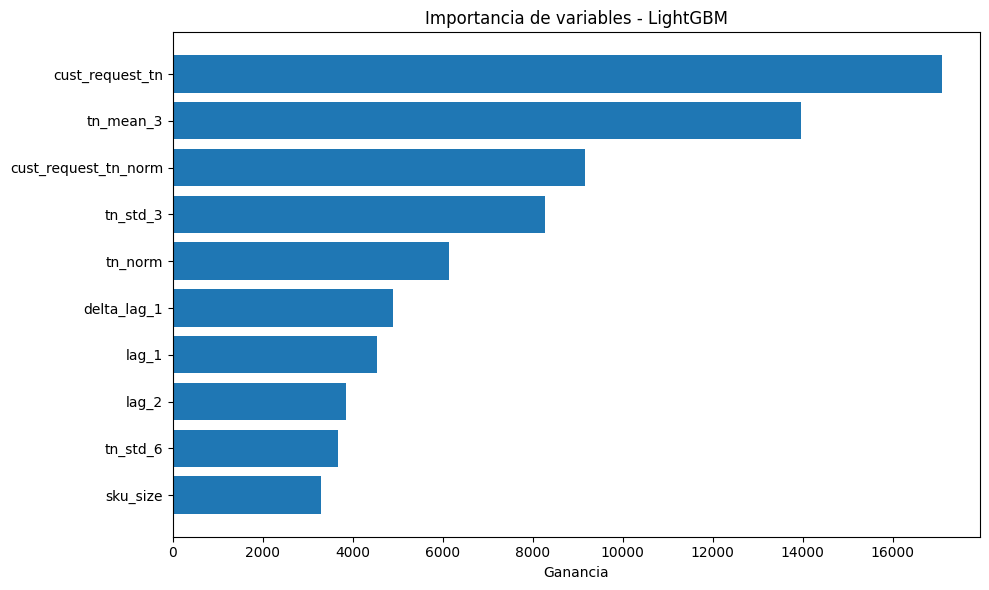

In [63]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()


In [67]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datos
df = pd.read_csv("top_20_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Crear lags sin perder features
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df)

# 3. Agregar variable mes
df_lags['mes'] = df_lags['periodo'].dt.month

# 4. Eliminar filas con NaN por los lags
df_train = df_lags.dropna()

# 5. Separar features y target
features = [col for col in df_train.columns if col not in ['tn', 'periodo', 'product_id']]
target = 'tn'

# 6. Separar train y validación
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

# 7. Hiperparámetros
mejores_params = {
    'n_estimators': 774,
    'learning_rate': 0.013833513325596666,
    'max_depth': 10,
    'num_leaves': 183,
    'subsample': 0.7698019331794512,
    'colsample_bytree': 0.7228716766181406,
    'random_state': 42,
    'min_data_in_leaf': 320,
    'reg_alpha': 0.5095229446241581,
    'reg_lambda': 1.616069961165865,
    'linear_tree': True
}

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 8. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 🔁 Preparar datos para enero 2020
enero_df = df[df['periodo'] == '2019-12-01'][['product_id']].drop_duplicates()
enero_df['periodo'] = pd.to_datetime('2020-01-01')
enero_df['mes'] = 1

# Lags por product_id únicos
lag_1 = df[df['periodo'] == '2019-12-01'].groupby('product_id', as_index=False)['tn'].sum().rename(columns={'tn': 'lag_1'})
lag_2 = df[df['periodo'] == '2019-11-01'].groupby('product_id', as_index=False)['tn'].sum().rename(columns={'tn': 'lag_2'})
lag_3 = df[df['periodo'] == '2019-10-01'].groupby('product_id', as_index=False)['tn'].sum().rename(columns={'tn': 'lag_3'})

# Merge seguros
enero_df = enero_df.merge(lag_1, on='product_id', how='left')
enero_df = enero_df.merge(lag_2, on='product_id', how='left')
enero_df = enero_df.merge(lag_3, on='product_id', how='left')

# Rellenar features faltantes si alguna quedó afuera
for col in features:
    if col not in enero_df.columns:
        enero_df[col] = 0

enero_df['tn'] = modelo.predict(enero_df[features])

# 🔁 Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = enero_df['product_id']
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2
feb_df['lag_1'] = enero_df['tn']
feb_df = feb_df.merge(lag_1.rename(columns={'lag_1': 'lag_2'}), on='product_id', how='left')
feb_df = feb_df.merge(lag_2.rename(columns={'lag_2': 'lag_3'}), on='product_id', how='left')

# Rellenar features
for col in features:
    if col not in feb_df.columns:
        if col in enero_df.columns:
            feb_df[col] = enero_df[col].values
        else:
            feb_df[col] = 0

feb_df['tn_predicho'] = modelo.predict(feb_df[features])

# ✅ Exportar
resultado = feb_df[['product_id', 'tn_predicho']]
resultado.to_csv("prediccion_feb2020_top203.csv", index=False)
print("✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top203.csv")


[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,664867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22173
[LightGBM] [Info] Number of data points in the train set: 1880862, number of used features: 108
[LightGBM] [Info] Start training from score 0,116306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\1183195854.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  enero_df[col] = 0
C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\1183195854.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  enero_df[col] = 0
C:\Users\waldo\AppData\Local\Temp\ipykernel_16112\1183195854.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [68]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top203.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_20_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo            tn
1  2017-02-01  5.702329e+03
2  2017-03-01  6.990975e+03
3  2017-04-01  5.915823e+03
4  2017-05-01  6.350694e+03
5  2017-06-01  6.246930e+03
6  2017-07-01  4.963103e+03
7  2017-08-01  5.394166e+03
8  2017-09-01  6.456906e+03
9  2017-10-01  7.469617e+03
10 2017-11-01  6.673993e+03
11 2017-12-01  5.439857e+03
12 2018-01-01  5.008785e+03
13 2018-02-01  5.276024e+03
14 2018-03-01  8.091699e+03
15 2018-04-01  5.935535e+03
16 2018-05-01  6.872361e+03
17 2018-06-01  6.240220e+03
18 2018-07-01  5.481642e+03
19 2018-08-01  6.211813e+03
20 2018-09-01  5.654182e+03
21 2018-10-01  6.470026e+03
22 2018-11-01  6.228278e+03
23 2018-12-01  4.976508e+03
24 2019-01-01  5.998070e+03
25 2019-02-01  6.210342e+03
26 2019-03-01  6.873227e+03
27 2019-04-01  6.573771e+03
28 2019-05-01  6.877301e+03
29 2019-06-01  6.301710e+03
30 2019-07-01  6.554508e+03
31 2019-08-01  5.666679e+03
32 2019-09-01  7.172001e+03
33 2019-


📌 Importancia de variables:
                 feature  importancia
3        cust_request_tn        17202
83             tn_mean_3        13977
11  cust_request_tn_norm         9119
84              tn_std_3         8318
10               tn_norm         6159
48           delta_lag_1         4766
12                 lag_1         4548
13                 lag_2         3834
86              tn_std_6         3700
9               sku_size         3314


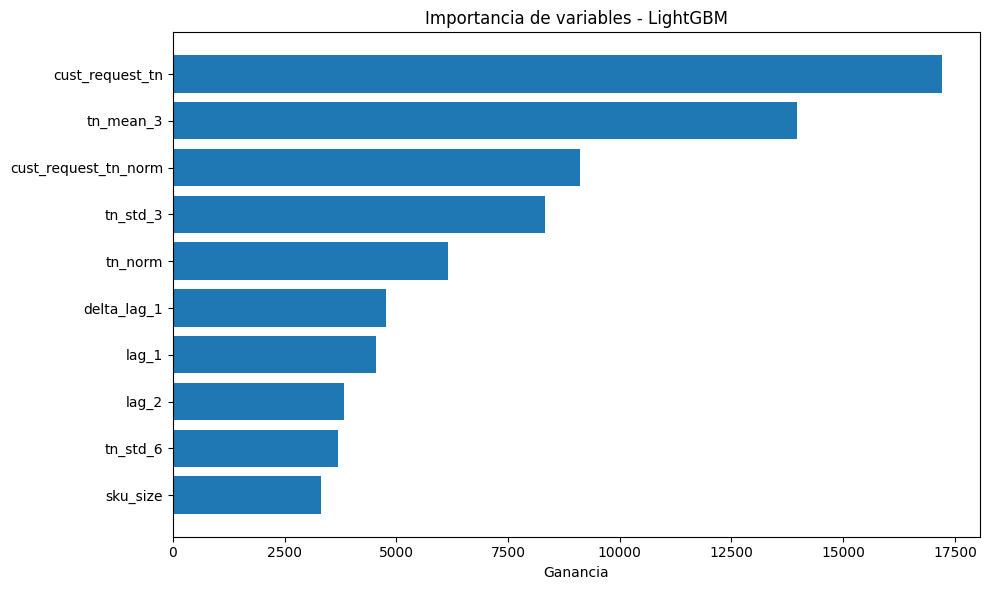

In [69]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()
